# SHAP Analysis for GBDT
This notebook contains the code for the SHAP analysis for a Gradient Boosted Decision Tree (GBDT) model.

Required libraries:
- ucimlrepo
- xgboost
- shap
- matplotlib
- scikit-learn
- pandas
- numpy

In [25]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import shap
from sklearn.metrics import RocCurveDisplay


warnings.filterwarnings("ignore", category=FutureWarning)

In [20]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

## Load the Data

In [14]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

In [15]:
# variable information
bank_marketing.variables.head()

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,None,no
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-colla...",None,no
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','marri...",None,no
3,education,Feature,Categorical,Education Level,"(categorical: 'basic.4y','basic.6y','basic.9y'...",None,no
4,default,Feature,Binary,None,has credit in default?,None,no


In [16]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (45211, 16)
y shape:  (45211, 1)


## Preprocess Dataset

### Convert the target variable to numeric

In [17]:
y = y.replace({"no": 0, "yes": 1})
y.value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

### Drop the `duration` column
The duration of the call is not available before the call is made,
and hence cannot be used for prediction.

In [18]:
X = X.drop(columns=["duration"])

### Convert categorical features to categorical datatype

In [19]:
obj_cols = X.select_dtypes(include="object").columns
for c in obj_cols:
    X[c] = pd.Categorical(X[c])
print("Number of categorical features: ", len(obj_cols))

Number of categorical features:  9


### Split dataset into train and test sets

In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(36168, 15) (9043, 15) (36168, 1) (9043, 1)


## Train model

In [24]:
xgb = XGBClassifier(enable_categorical=True)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

## Evaluate

Text(105.9222222222222, 0.5, 'True Positive Rate: (Positive Class: yes)')

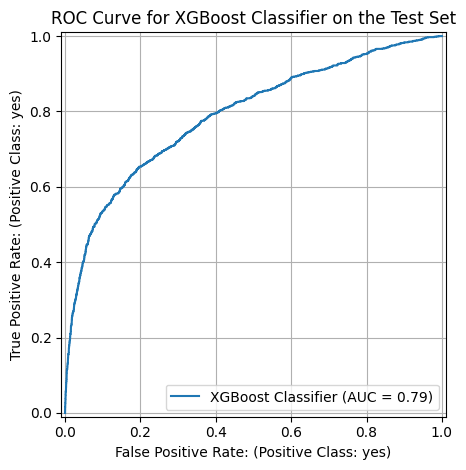

In [26]:
ax = plt.gca()
ax.grid(True)
ax.set_title("ROC Curve for XGBoost Classifier on the Test Set")
_ = RocCurveDisplay.from_estimator(
    xgb, x_test, y_test, ax=ax, name="XGBoost Classifier"
)
plt.tight_layout()
ax.set_xlabel("False Positive Rate: (Positive Class: yes)")
ax.set_ylabel("True Positive Rate: (Positive Class: yes)")
# plt.savefig("../roc_xgb.png")

In [27]:
print("Train accuracy: ", xgb.score(x_train, y_train))
print("Test accuracy: ", xgb.score(x_test, y_test))

Train accuracy:  0.9355784118557842
Test accuracy:  0.8917394669910428


## SHAP Analysis

In [28]:
shap.initjs()

In [29]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer(x_test)

shap_values.shape

(9043, 15)

### Global Explanations

#### Bar Plot

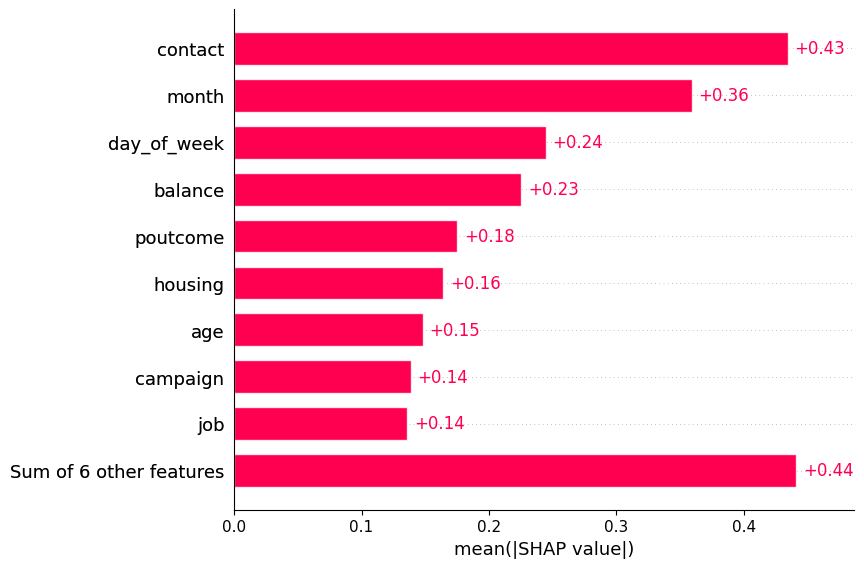

In [32]:
shap.plots.bar(shap_values)

#### Beeswarm Plot

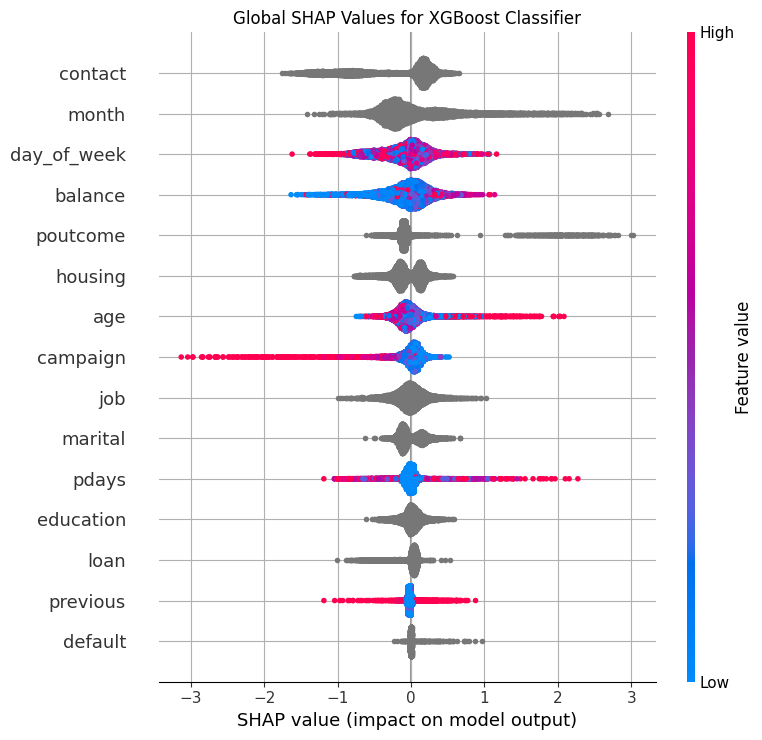

In [31]:
ax = plt.subplot()
ax.grid(True)
ax = shap.plots.beeswarm(shap_values, max_display=16, show=False, log_scale=False)
ax.set_title("Global SHAP Values for XGBoost Classifier")
plt.tight_layout()
# plt.savefig("../beeswarm_xgb.png")

### Dependency Explanations

In [34]:
def plot_shap_categorical(
    shap_values: shap.Explanation,
    x: pd.DataFrame,
    feature_name: str,
    save_path: str = None,
) -> plt.Axes:
    """Plot SHAP dependence plot for a categorical feature.

    Args:
        shap_values (shap.Explanation): SHAP values for the test set.
        x (pd.DataFrame): Test set.
        feature_name (str): Name of the categorical feature.
        save_path (str, optional): Path to save the plot. Defaults to None.

    Returns:
        plt.Axes: Axes object for the plot.
    """
    feature_idx = x.columns.tolist().index(feature_name)
    feature_values = x.iloc[:, feature_idx]
    shap_values_feature = shap_values[:, feature_idx].values

    # Map categories to numeric values for plotting
    categories = feature_values.unique()
    category_to_num = {cat: num for num, cat in enumerate(categories)}
    feature_values_numeric = feature_values.map(category_to_num)

    # Create scatter plot with categories on x-axis
    _, ax = plt.subplots(figsize=(10, 6))
    # plt.figure(figsize=(10, 6))
    ax.scatter(
        feature_values_numeric,
        shap_values_feature,
        alpha=0.7,
        s=120,
    )

    # Replace numeric x-ticks with category labels
    ax.set_xticks(
        ticks=np.arange(len(categories)), labels=categories, rotation=45, fontsize=12
    )

    # Reference line at y=0
    ax.axhline(y=0, color="gray", linestyle="--")

    # Labels and title
    ax.grid(True)
    ax.set_xlabel(f"Categorical Feature: {feature_name}")
    ax.set_ylabel("SHAP Value")
    ax.set_title(f"SHAP Dependence Plot for Categorical Feature '{feature_name}'")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    return ax

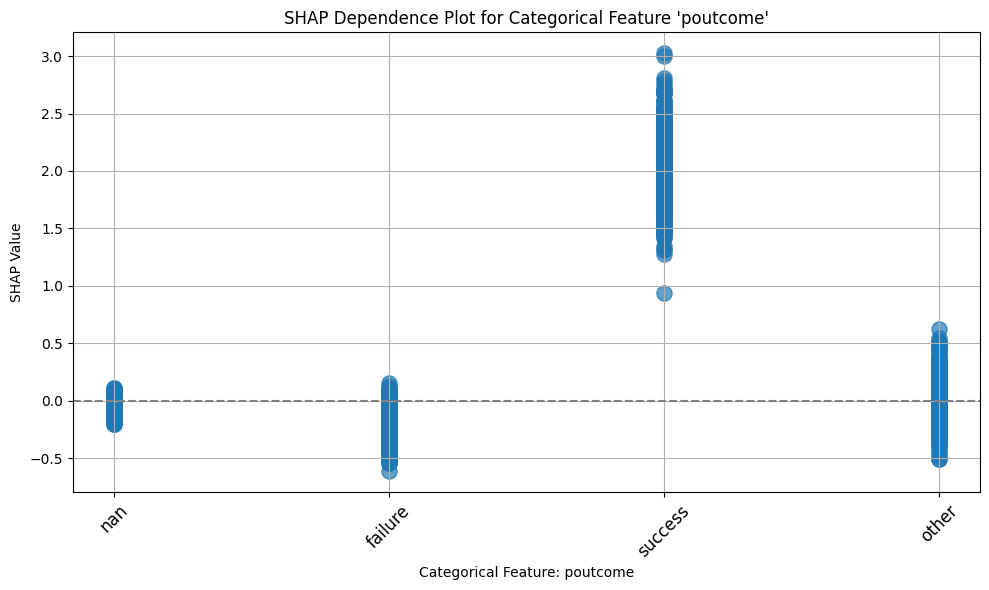

In [35]:
ax = plot_shap_categorical(shap_values, x_test, "poutcome", "../dep_poutcome_xgb.png")

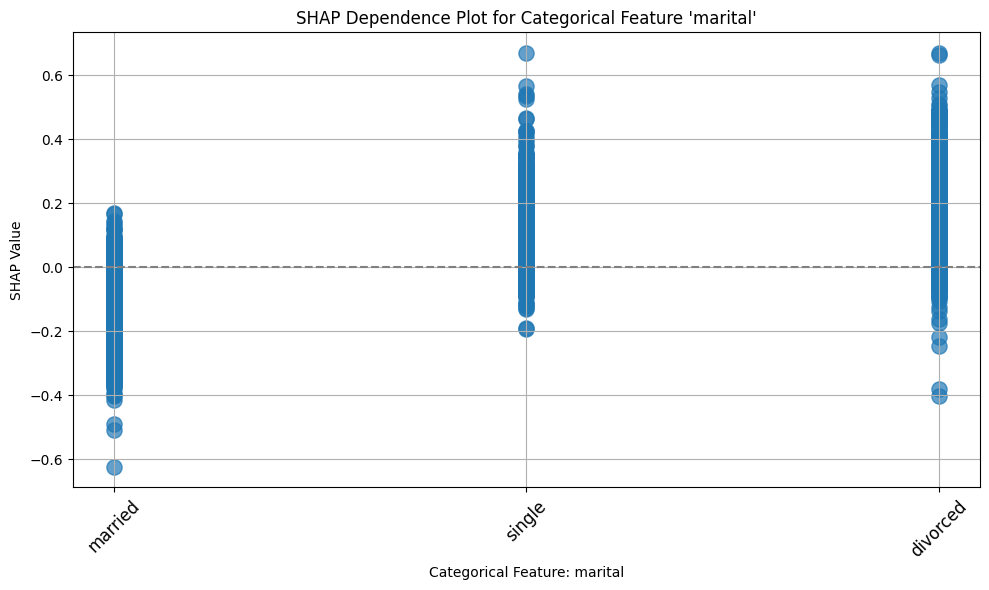

In [36]:
ax = plot_shap_categorical(shap_values, x_test, "marital")

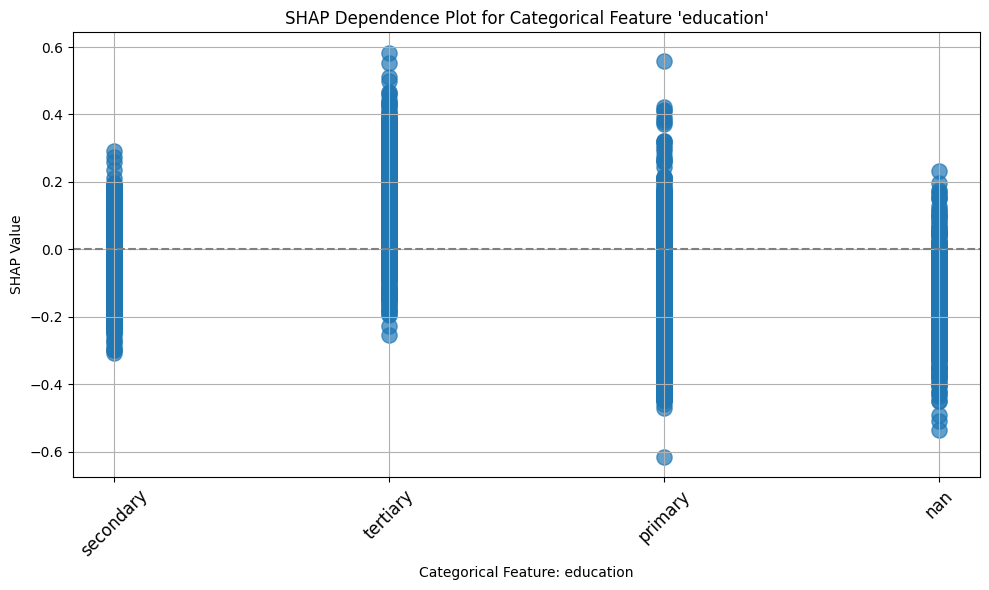

In [37]:
ax = plot_shap_categorical(shap_values, x_test, "education")

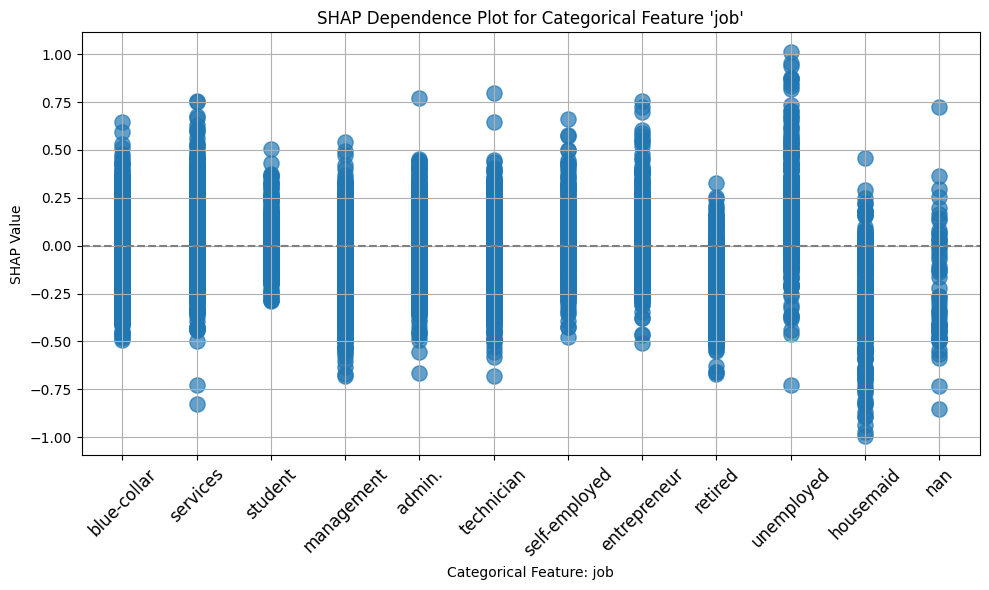

In [38]:
ax = plot_shap_categorical(shap_values, x_test, "job")

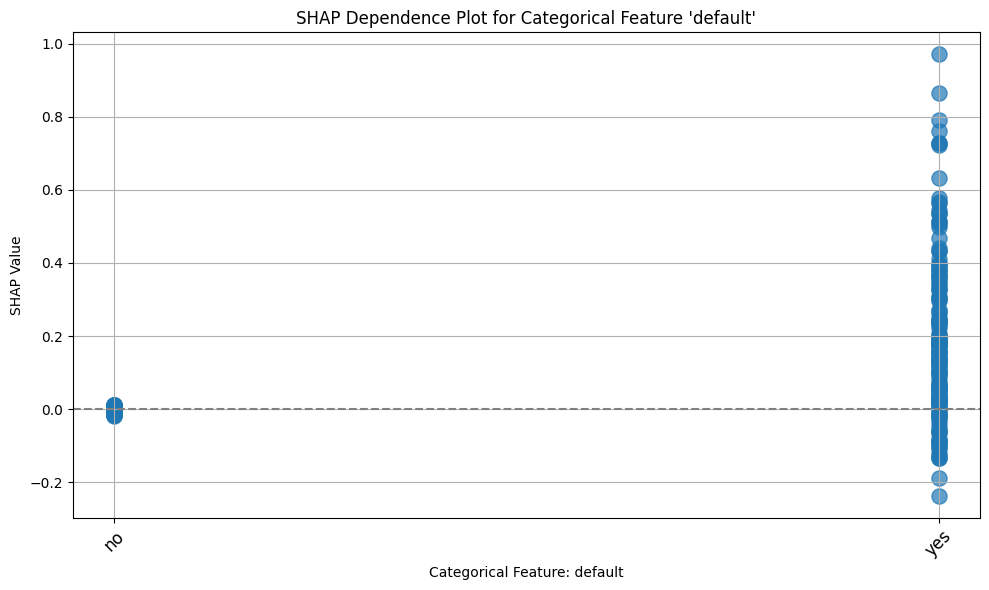

In [39]:
ax = plot_shap_categorical(shap_values, x_test, "default")

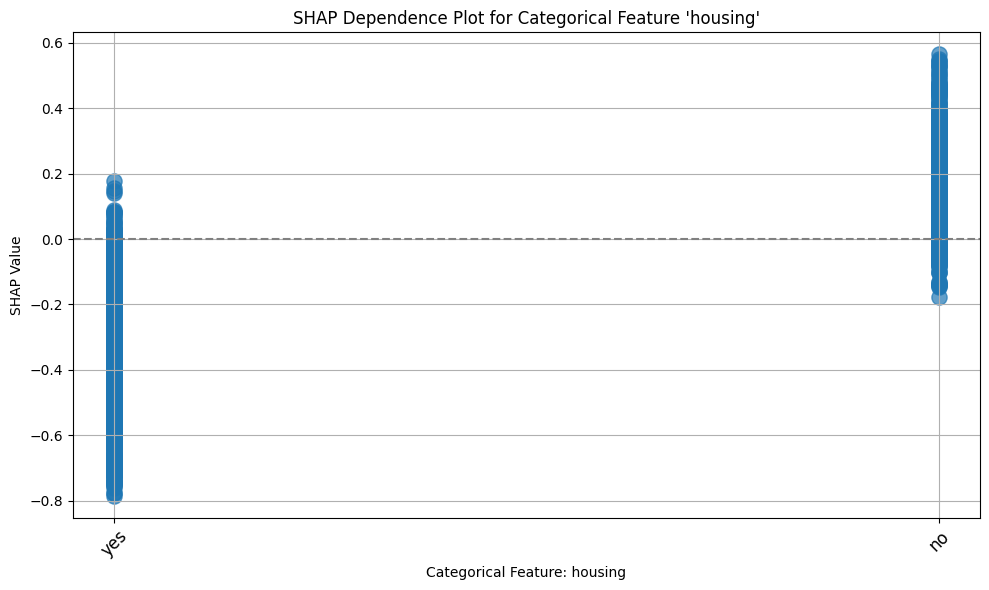

In [82]:
ax2 = plot_shap_categorical(shap_values, x_test, "housing")

In [40]:
def plot_shap_dependence_subplots(
    features: list[str],
    xgb_model: XGBClassifier,
    shap_values: shap.Explanation,
    x_test: pd.DataFrame,
):
    """
    Plot SHAP dependence plots for multiple categorical features in subplots.

    Args:
        features (list[str]): List of feature names to plot.
        xgb_model (XGBClassifier): Trained XGBoost model.
        shap_values (shap.Explanation): SHAP values for the test set.
        x_test (pd.DataFrame): Test set.
    """
    num_features = len(features)
    cols = 2
    rows = (num_features + 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))

    for i, feature_name in enumerate(features):
        ax = axes.flatten()[i]

        feature_idx = xgb_model.feature_names_in_.tolist().index(feature_name)
        feature_values = x_test.iloc[:, feature_idx]
        shap_values_feature = shap_values[:, feature_idx].values

        categories = feature_values.unique()
        category_to_num = {cat: num for num, cat in enumerate(categories)}
        feature_values_numeric = feature_values.map(category_to_num)

        ax.scatter(
            feature_values_numeric,
            shap_values_feature,
            alpha=0.7,
            s=50,
            color="dodgerblue",
        )

        ax.axhline(y=0, color="gray", linestyle="--")
        ax.set_xticks(np.arange(len(categories)))
        ax.set_xticklabels(categories, rotation=45)
        ax.set_xlabel(f"{feature_name}")
        ax.set_ylabel("SHAP Value")
        ax.set_title(f"SHAP Dependence: {feature_name}")
        ax.grid(True)

    # Remove any unused subplots
    if num_features < rows * cols:
        for j in range(num_features, rows * cols):
            fig.delaxes(axes.flatten()[j])

    fig.tight_layout()

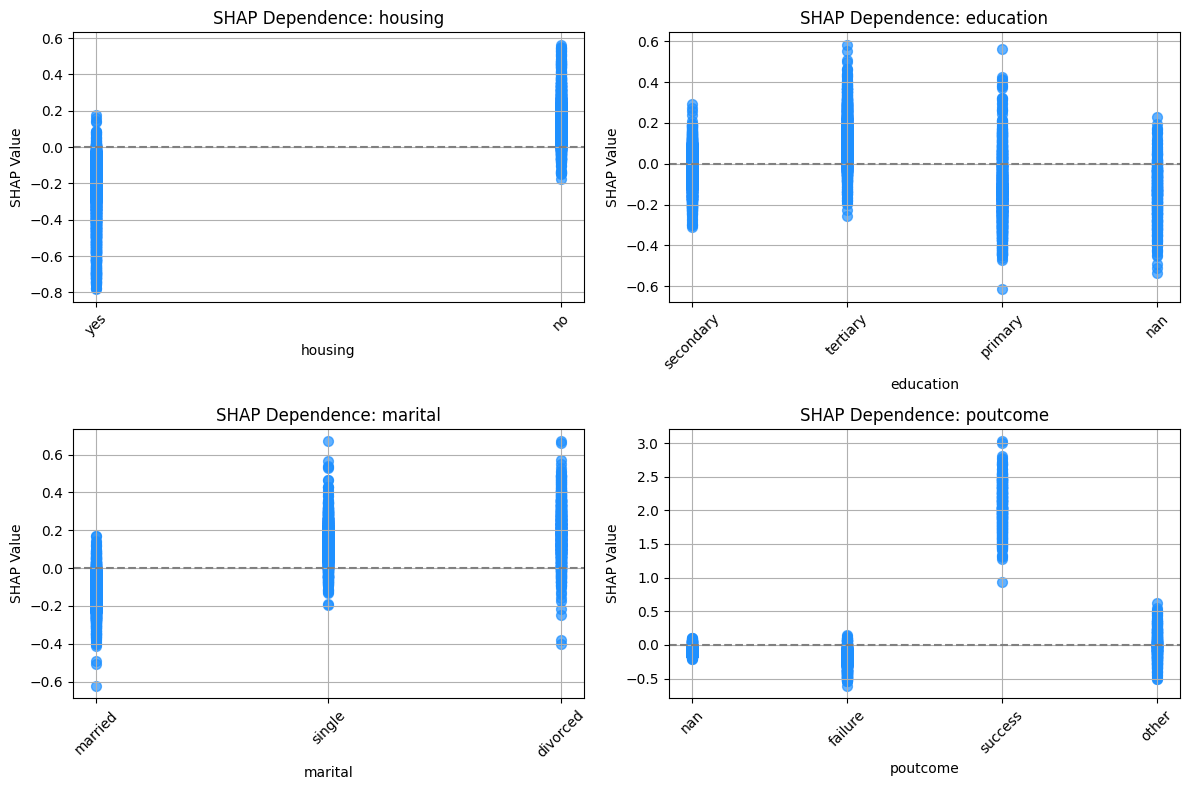

In [41]:
features = ["housing", "education", "marital", "poutcome"]
plot_shap_dependence_subplots(
    features, xgb_model=xgb, shap_values=shap_values, x_test=x_test
)
plt.savefig("../dep_categorical_xgb.png")